In [2]:
!pip install contractions -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, dataloader
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data analysis

In [4]:
# Load datasets
fake_df = pd.read_csv("/content/drive/MyDrive/Fake_and_real_news/Fake.csv")
real_df = pd.read_csv("/content/drive/MyDrive/Fake_and_real_news/True.csv")

In [5]:
fake_df['label'] = 0
real_df['label'] = 1

df  = pd.concat([fake_df, real_df], ignore_index=True)
df  = df.sample(frac=1, random_state=42). reset_index(drop=True)

# Combine title and text
df['combined_text'] = df['title'] + " " + df['text']

In [6]:
def clean_text(text):
  if isinstance(text, bytes):
      text = text.decode('utf-8') # Or the appropriate encoding if not utf-8

  text = contractions.fix(text)   # Expand contractions

  # Ensure text is a string after contractions.fix()
  if isinstance(text, bytes):
      text = text.decode('utf-8') # Decode if contractions.fix returned bytes

  text = text.encode("ascii", errors="ignore").decode() #Remove non-ASCII characters
  text = text.lower()       #Lower case
  text = re.sub(r"http\S+|www.\S+", "", text)   #Remove URLs
  text = re.sub(r"<.*?>", "",text)    #Remove HTML tags
  text = re.sub(r"[^a-z\s]", "", text)   #Keep only letters and spaces
  text = re.sub(r"\b\w{1}\b", "", text)   #Remove single letter words
  text = re.sub(r"\s+", " ", text).strip()     #Remove extra spaces
  words = text.split()
  words = [word for word in words if word not in stop_words]    #Remove stopwords
  return " ".join(words)

In [7]:
df['clean_text'] = df['combined_text'].apply(clean_text)
df[['clean_text', 'label']].head()

,clean_text,label
0,ben stein calls th circuit court committed cou...,0
1,trump drops steve bannon national security cou...,1
2,puerto rico expects yous lift jones act shippi...,1
3,oops trump accidentally confirmed leaked israe...,0
4,donald trump heads scotland reopen golf resort...,1


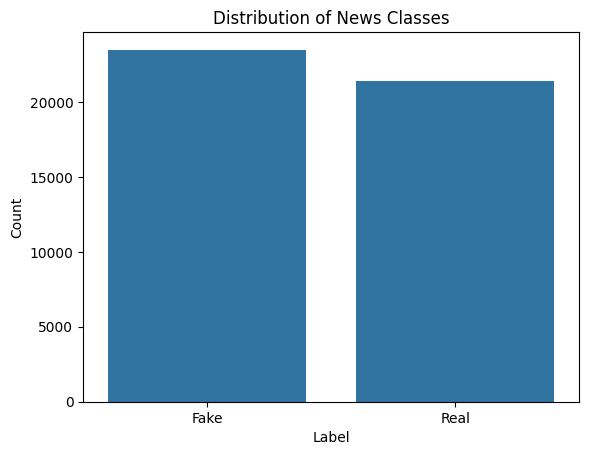

In [8]:
sns.countplot(x="label", data=df)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Distribution of News Classes")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

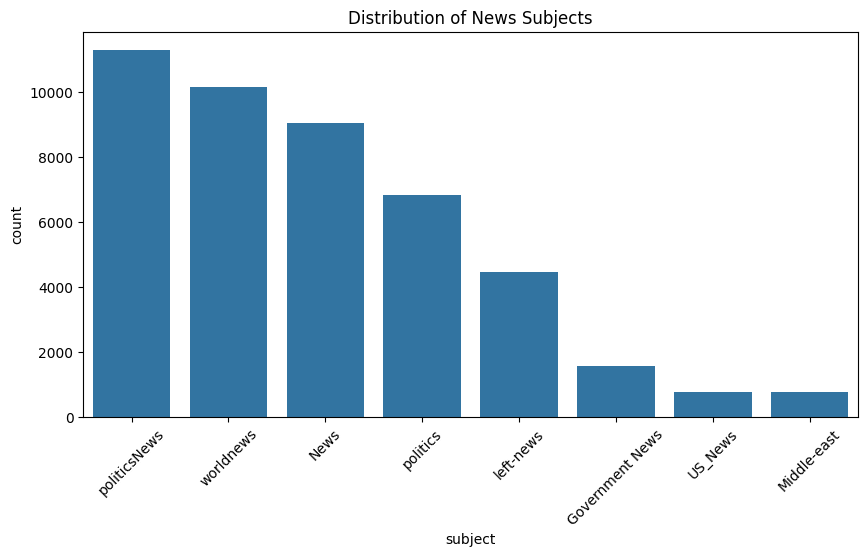

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="subject", order=df["subject"].value_counts().index)
plt.title("Distribution of News Subjects")
plt.xticks(rotation=45)
plt.show()

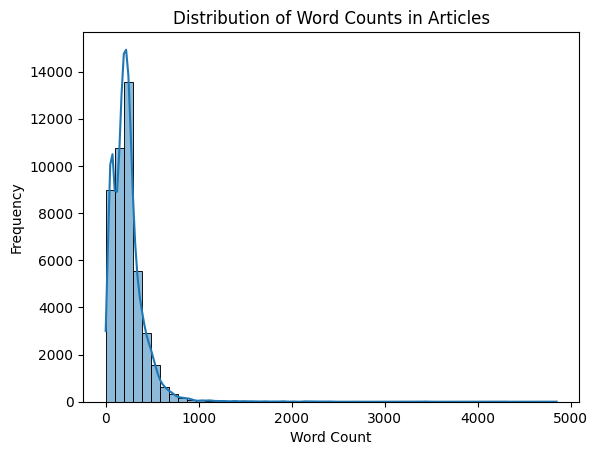

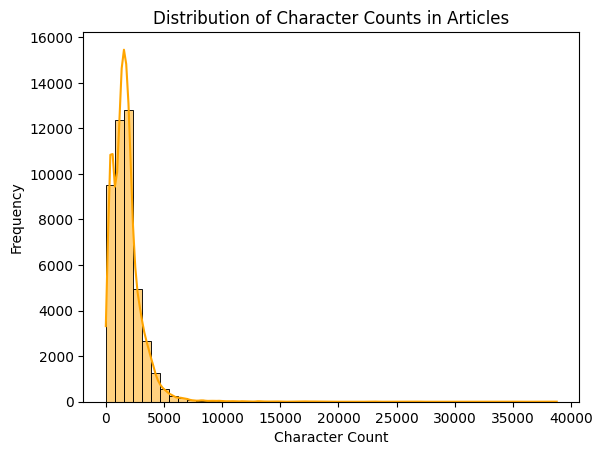

In [10]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
df["char_length"] = df["clean_text"].apply(len)

# Word count
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution of Word Counts in Articles")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Character count
sns.histplot(df["char_length"], bins=50, kde=True, color='orange')
plt.title("Distribution of Character Counts in Articles")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

Final Data Frame

In [11]:
df

,title,text,subject,date,label,combined_text,clean_text,text_length,char_length
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein calls th circuit court committed cou...,109,802
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,Trump drops Steve Bannon from National Securit...,trump drops steve bannon national security cou...,472,3613
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects yous lift jones act shippi...,182,1347
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...,114,943
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,Donald Trump heads for Scotland to reopen a go...,donald trump heads scotland reopen golf resort...,305,2278
...,...,...,...,...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",0,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,unreal cbss ted koppel tells sean hannity bad ...,10,59
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",1,PM May seeks to ease Japan's Brexit fears duri...,pm may seeks ease japans brexit fears trade vi...,429,3224
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",1,Merkel: Difficult German coalition talks can r...,merkel difficult german coalition talks reach ...,45,341
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",0,Trump Stole An Idea From North Korean Propaga...,trump stole idea north korean propaganda parod...,480,3279


##Text Tokenization

In [12]:
tokenized_texts = [text.split() for text in df['clean_text']]

In [13]:
# Build vocabulary
word_counter = Counter(word for tokens in tokenized_texts for word in tokens)
vocab_size = 10000          # Limit vocab size
most_common = word_counter.most_common(vocab_size  - 2)

In [14]:
# Create word-to-index mappings
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
idx2word = {idx: word for word, idx in word2idx.items()}

##Dataset Preparation

In [15]:
# Function to convert tokens to indices
def encode(tokens, word2idx, max_len):
  ids = [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]
  if len(ids) < max_len:
    ids += [word2idx["<PAD>"]]* (max_len - len(ids))
  else:
    ids = ids[:max_len]
  return ids

In [16]:
max_len = 300
encoded_texts = [encode(tokens, word2idx, max_len) for tokens in tokenized_texts]
labels = df['label']. values

In [17]:
# create the custom dataset
class NewsDataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = torch.tensor(inputs, dtype=torch.long)
    self.labels = torch.tensor(labels, dtype=torch.float32)

  def __len__(self):
    return len(self.labels)


  def __getitem__ (self, idx):
    return self.inputs[idx], self.labels[idx]

Split the data into Train, Val and Test splits

In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(
    encoded_texts, labels, test_size=0.30, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [19]:
# Create datasets
train_dataset = NewsDataset(X_train, y_train)
val_dataset = NewsDataset(X_val, y_val)
test_dataset = NewsDataset(X_test, y_test)

In [20]:
train_dataset[0]

(tensor([4420, 1918,   39,  516,   35,   88, 9491,  127,   70,    3, 2898,   24,
            8,  413, 1348,  306,   70,    3,  412, 1918,  965,  127,   70,   14,
            3, 3105,  132,    1,    1,  934,    1,  757,  826,   38,  706, 2618,
           19,  318,   86,  115, 2090,   36, 1174,    1, 3299,    3,  909,  353,
          465, 1596,   38, 1334,   32,    1,  350,   27,   34,    1, 6685,  111,
          374,  411,  227,   39,   24,   22,   16, 2678,  432,    5,  750,   64,
            7,   50,  589,  153,   22,   16,    1,    2,   78, 4546,  219,    1,
          295,  560,   56,  476,   55,   90,  997,  182, 3458,   70,    3,  153,
         1549,   58,  412,  757, 3127,   88,   15,    1, 2240,  300, 2017,  135,
          836, 1767,  685, 4673, 3268,  477,  801,    1, 5532,  412, 1711,  709,
           61,   15,  580,  745, 2952,   30,   35,  934,  125,   10,   11, 1091,
          469, 1347,  135,  169, 1217, 2188,  745,    6,  258, 1711,   42,   11,
           15,  685,    1,  

In [24]:
# Create data loaders
batch_size = 32

train_loader = dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = dataloader.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = dataloader.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Choose the model

In [25]:
class LSTMClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_layers=1,
               dropout=0.5, bidirectional=True):
    super(LSTMClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        batch_first=True,
        bidirectional=bidirectional,
        dropout=dropout if num_layers > 1 else 0
    )
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
    lstm_out, _ = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim * num_directions]
    # Take the hidden state (can use mean or max pooling too
    last_hidden = lstm_out[:, -1, :]  # [batch_size, hidden_dim * num_directions]
    out = self.dropout(last_hidden)
    out = self.fc(out)
    return self.sigmoid(out).squeeze()

In [26]:
model = LSTMClassifier(
    vocab_size=len(word2idx),
    embedding_dim=100,
    hidden_dim=128,
    num_layers=1,
    dropout=0.5,
    bidirectional=True
)

In [29]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [30]:
model = model.to(device)

## Model Training

In [27]:
# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [28]:
num_epochs = 10

In [32]:
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  correct, total = 0, 0

  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
  for inputs, labels in loop:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * inputs.size(0)

    preds = (outputs >= 0.5).float()
    correct += (preds == labels).sum().item()
    total += labels.size(0)

    # Update progress bar
    loop.set_postfix(loss=loss.item())

  train_acc = correct / total
  avg_train_loss = train_loss / total

  # validation
  model.eval()
  val_loss, val_correct, val_total = 0.0, 0, 0
  with torch.no_grad():
    val_loop = tqdm(val_loader, desc="validation", leave=False)
    for inputs, labels in val_loop:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)

      loss = criterion(outputs, labels)
      val_loss += loss.item() * inputs.size(0)

      preds = (outputs >= 0.5).float()
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

      val_loop.set_postfix(val_loss=loss.item())

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / val_total

    # Epoch summary
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


[Epoch 1] Train Loss: 0.6688 | Train Acc: 0.5717 | Val Loss: 0.6677 | Val Acc: 0.5710


[Epoch 2] Train Loss: 0.5121 | Train Acc: 0.7436 | Val Loss: 0.3615 | Val Acc: 0.8777


[Epoch 3] Train Loss: 0.5198 | Train Acc: 0.6980 | Val Loss: 0.6433 | Val Acc: 0.5645


[Epoch 4] Train Loss: 0.3737 | Train Acc: 0.8330 | Val Loss: 0.1030 | Val Acc: 0.9724


[Epoch 5] Train Loss: 0.1139 | Train Acc: 0.9727 | Val Loss: 0.0788 | Val Acc: 0.9803


[Epoch 6] Train Loss: 0.0909 | Train Acc: 0.9788 | Val Loss: 0.0617 | Val Acc: 0.9868


[Epoch 7] Train Loss: 0.0463 | Train Acc: 0.9916 | Val Loss: 0.0437 | Val Acc: 0.9920


[Epoch 8] Train Loss: 0.0331 | Train Acc: 0.9940 | Val Loss: 0.0320 | Val Acc: 0.9941


[Epoch 9] Train Loss: 0.0779 | Train Acc: 0.9767 | Val Loss: 0.5818 | Val Acc: 0.5834


[Epoch 10] Train Loss: 0.1656 | Train Acc: 0.9429 | Val Loss: 0.0440 | Val Acc: 0.9875


## Model Evaluation

In [35]:
def evaluate_model(model, dataloader, device, title="Confusion Matrix"):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      preds = (outputs >=0.5).float()

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  # Convert to numpy arrays
  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)

  # Compute evaluation metrics
  acc = accuracy_score(all_labels, all_preds)
  prec = precision_score(all_labels, all_preds)
  rec = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)


  print(f"Evaluation Metrics:")
  print(f"Accuracy: {acc:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"F1 Score: {f1:.4f}")

  # Confusion Matrix
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(title)
  plt.show()

Evaluation Metrics:
Accuracy: 0.9881
Precision: 0.9863
Recall: 0.9888
F1 Score: 0.9876


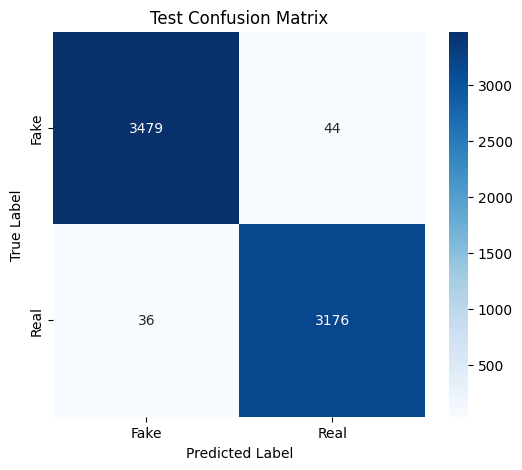

In [36]:
evaluate_model(model, test_loader, device, title="Test Confusion Matrix")

## Save the model

In [ ]:
torch.save(model, 'model.pt')